# CS6208 Paper Review

Implementation of Self-tuning Spectral Clustering essay: https://authors.caltech.edu/65341/1/2619-self-tuning-spectral-clustering.pdf

Zhang Xinyang
e0983283@u.nus.edu

In [106]:
import numpy as np
from itertools import groupby
from scipy.linalg import eigh, inv, sqrtm
from scipy.stats import spearmanr
from autograd import numpy as npy
from scipy.optimize import minimize
from autograd import grad
from sklearn.datasets import load_iris, load_wine
import time
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def plot_tsne(feats, labels):
  """
  Args:
      feats: shape [#datapoints, #features]
      labels: shape [#datapoints]
  """
  
  features_2d = TSNE(2).fit_transform(feats)
  x = features_2d[:,0]
  y = features_2d[:,1]
  plt.scatter(x, y, c = labels, cmap='tab20')
  plt.show()


def generate_orthogonal_matrix(i_list, j_list, theta_list, size):
  """
  Args:
      i_list: shape [size*(size-1)/2]
      j_list: shape [size*(size-1)/2]
      theta_list: shape [size*(size-1)/2]
      size: #clusters
  Return: orthogonal_matrix: shape [size,size]

  """
  orthogonal_matrix = npy.eye(size)
  for i, j, theta in zip(i_list, j_list, theta_list):
    gen_matrix = npy.eye(size)
    cos_theta = npy.cos(theta)
    sin_theta = npy.sin(theta)
    gen_matrix[i,i] = 0
    gen_matrix[j,j] = 0
    gen_matrix[j,i] = 0
    gen_matrix[i,j] = 0
    ii_matrix = npy.zeros_like(gen_matrix)
    ii_matrix[i,i] = 1
    jj_matrix = npy.zeros_like(gen_matrix)
    jj_matrix[j,j] = 1
    ji_matrix = npy.zeros_like(gen_matrix)
    ji_matrix[j,i] = 1
    ij_matrix = npy.zeros_like(gen_matrix)
    ij_matrix[i,j] = 1
    temp_matrix = gen_matrix + cos_theta * ii_matrix + cos_theta * jj_matrix + sin_theta * ji_matrix - sin_theta * ij_matrix
    orthogonal_matrix = npy.dot(orthogonal_matrix,temp_matrix)

  return orthogonal_matrix


def get_rotation_matrix(X_matrix, num_cluster):
  """
  Args:
      X_matrix: shape [size*(size-1)/2]
      num_cluster: #clusters
  Return: 
      opt.fun: minimized cost
      generate_orthogonal_matrix(i_list, j_list, opt.x, num_cluster): orthogonal_matrix that minimized cost

  """
  i_list = []
  j_list = []
  for j in range(num_cluster):
    for i in range(num_cluster):
      if i<j:
        i_list.append(i)
        j_list.append(j)

  def cost(theta_list):
    """
    help function for minimize(), calculate the cost based on the definition of J eq(3) in Self-tuning Spectral Clustering essay

    """
    R_matrix = generate_orthogonal_matrix(i_list, j_list, theta_list, num_cluster)
    Z_matrix = X_matrix.dot(R_matrix)
    M_matrix = npy.max(Z_matrix, axis=1, keepdims=True)
    return npy.sum((Z_matrix / M_matrix) ** 2)

  theta_list_init = npy.array([0.0] * int(num_cluster * (num_cluster - 1) / 2))
  opt = minimize(cost,
          x0=theta_list_init,
          method='CG',
          jac=grad(cost),
          options={'disp': False})
  
  return opt.fun, generate_orthogonal_matrix(i_list, j_list, opt.x, num_cluster)


def get_eigvalue_eigvector(similarity_matrix):
  """
  Args:
      similarity_matrix: shape [#datapoints,#datapoints]
  Return: 
      eigvalue: eigvalue of similarity_matrix
      eigvector: eigvector of similarity_matrix

  """
  A_matrix = np.triu(similarity_matrix, k=1)+np.tril(similarity_matrix, k=-1)
  D_matrix = np.diag(A_matrix.sum(axis=0))
  D2_matrix = inv(sqrtm(D_matrix))
  L_matrix = D2_matrix.dot(A_matrix).dot(D2_matrix)
  eigvalue, eigvector = eigh(L_matrix)

  return eigvalue, eigvector


def get_cluster_range(eigvalue, min_n_cluster, max_n_cluster):
  """
  Get the range of the #clusters based on the eigvalue

  """
  if max_n_cluster is None:
    max_n_cluster = max(np.sum(eigvalue > 0),2)
  assert min_n_cluster <= max_n_cluster,'min_n_cluster > max_n_cluster'
  print("cluster range:",min_n_cluster,'-',max_n_cluster)

  return min_n_cluster, max_n_cluster


def self_tuning_spectral_clustering(data, min_n_cluster=2, max_n_cluster=None):
  """
  Args:
      data: shape [#features, #datapoints]
  Return:
      cluster_target: shape [#datapoints]
      time_cost_list: time cost of each cluster number
  """
  similarity_matrix = np.abs(spearmanr(data).correlation)
  eigvalue, eigvector = get_eigvalue_eigvector(similarity_matrix)
  min_n_cluster, max_n_cluster = get_cluster_range(eigvalue, min_n_cluster, max_n_cluster)
  best_cost = np.inf
  best_Z = None
  time_cost_list = [[],[]]

  for num_c in range(min_n_cluster, max_n_cluster + 1):
    start_time = time.time()
    X_matrix = eigvector[:, -num_c:]
    cost, R_matrix = get_rotation_matrix(X_matrix, num_c)
    if cost < best_cost:
      best_cost = cost
      best_Z = X_matrix.dot(R_matrix)
    end_time = time.time()
    print('n_cluster: %d \t cost: %f' % (num_c, cost))
    print('time cost:',float(end_time-start_time),'s')
    time_cost_list[0].append(num_c)
    time_cost_list[1].append(float(end_time-start_time))
  
  zipped_data = sorted(zip(np.argmax(best_Z, axis=1), range(best_Z.shape[0])), key=lambda x: x[0])
  grouped_result = groupby(zipped_data, lambda x: x[0])
  cluster_target = np.zeros(data.shape[1],dtype = int)
  for group in grouped_result:
    for i in group[1]:
      cluster_target[i[1]] = int(group[0])

  return cluster_target, time_cost_list

In [107]:
iris = load_iris()

In [108]:
print(iris.data.shape)
print(iris.target.shape)

(150, 4)
(150,)


In [109]:
iris_result,iris_time_cost = self_tuning_spectral_clustering(iris.data.T)

cluster range: 2 - 2
n_cluster: 2 	 cost: 150.000000
time cost: 2.274775743484497 s


In [110]:
iris_result

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [111]:
iris.target

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

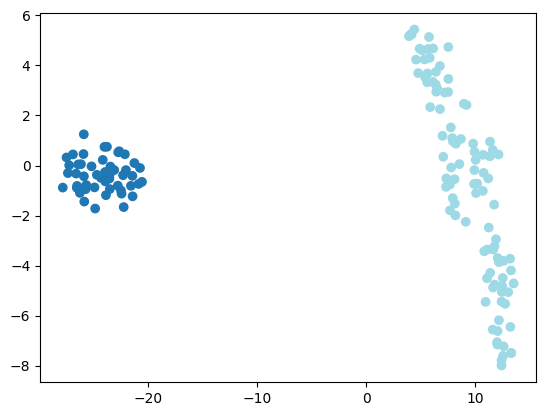

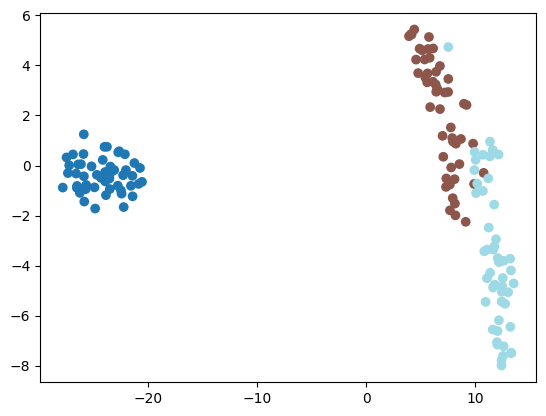

In [112]:
plot_tsne(iris.data, iris_result)
plot_tsne(iris.data, iris.target)

In [113]:
wine = load_wine()

In [114]:
print(wine.data.shape)
print(wine.target.shape)

(178, 13)
(178,)


In [115]:
wine_result,wine_time_cost = self_tuning_spectral_clustering(wine.data.T)

cluster range: 2 - 6
n_cluster: 2 	 cost: 196.350660
time cost: 3.0172457695007324 s
n_cluster: 3 	 cost: 8434.120501
time cost: 19.553203344345093 s
n_cluster: 4 	 cost: 37657.205228
time cost: 104.60746264457703 s
n_cluster: 5 	 cost: 13513.835069
time cost: 71.76575970649719 s
n_cluster: 6 	 cost: 6788.195605
time cost: 82.07007646560669 s


In [116]:
wine_result

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1])

In [117]:
wine.target

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2])

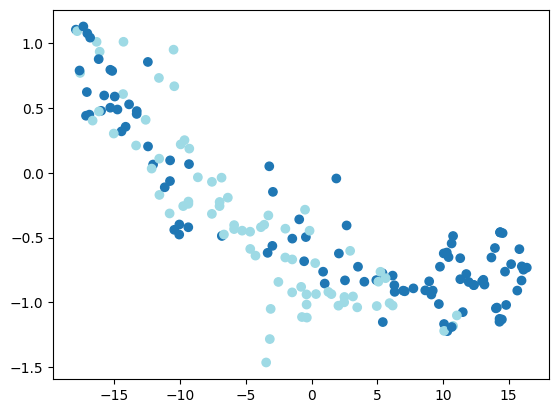

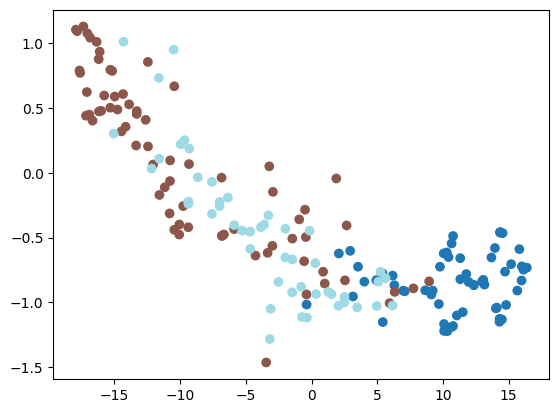

In [118]:
plot_tsne(wine.data, wine_result)
plot_tsne(wine.data, wine.target)